In [1]:
from pathlib import Path
import pandas as pd
import plotly.express as px
from lz4.frame import compress
import math
import numpy as np
from english_words import get_english_words_set
from itertools import product
import random
from collections import Counter
web2lowerset = get_english_words_set(['web2'], lower=True)
words = [x for x in web2lowerset if 5< len(x) < 10]

ModuleNotFoundError: No module named 'english_words'

In [ ]:
data_file = "data/movies.csv"
data_tokens = list(pd.read_csv(data_file).columns)
data_tokens.append(data_file)


In [4]:
dt_by_spec = dict()
for notation in Path("galleries/movies/").glob("*"):
    print(notation.stem)
    for spec in notation.glob("*"):
        if spec.is_dir(): continue
        contents = spec.read_text()
        tokens = [dt for dt in data_tokens if dt in contents]
        if spec.stem in dt_by_spec and dt_by_spec[spec.stem] != tokens:
            print(spec.stem, dt_by_spec[spec.stem], tokens)
        dt_by_spec[spec.stem] = tokens


seaborn
ggplot2
vega-lite
matplotlib
plotly_express


In [5]:
def get_num_slots(tokens_per_slot, num_specs):
  return math.ceil(math.log(num_specs, tokens_per_slot))

In [32]:
def synthetic_specs(tokens_per_slot, dt_by_spec, unique_across_slots=True):
    random.seed(1)
    num_specs = len(dt_by_spec)
    num_slots = get_num_slots(tokens_per_slot, num_specs)
    counters = [Counter() for i in range(num_slots)]
    all_specs = list(product(range(tokens_per_slot), repeat=num_slots))
    result = []
    mult = tokens_per_slot if unique_across_slots else 0
    for combo in random.sample(all_specs, num_specs):
        tokens = []
        for i, v in enumerate(combo):
            t = words[i*mult+v]
            tokens.append(t)
            counters[i].update([t])
        result.append(tokens)
    max_counts = [c.most_common(1)[0][1] for c in counters]
    defaults = [c.most_common(1)[0][0] for c in counters]
    result = np.array(result)[:,np.argsort(max_counts)]
    defaults = np.array([c.most_common(1)[0][0] for c in counters])[np.argsort(max_counts)]
    for r in result:
        for i, (d, t) in enumerate(zip(r, defaults)):
            if d==t:
                r[i] = "@@"

    # sort results contents by counters, then replace the highest per column by blank, if the rightmost is already blank?
    return ["\n".join(list(r)+dts).replace("@@\n", "") for r, (_, dts) in zip(result, dt_by_spec.items())]


In [33]:
def num_tokens(specs):
    tokens = set()
    for s in specs:
        for t in s.split("\n"):
            tokens.add(t)
    return len(tokens)

In [34]:
def lc(x):
  return len(compress(x.encode("utf8")))
  
def nmi(s1,s2):
  if s1 == s2: return 0
  return 2*lc(s1+s2) - lc(s1) - lc(s2)

def distance_matrix(specs):
  return np.array([[nmi(s1, s2) for s2 in specs] for s1 in specs])

def mean_remoteness(specs):
  return np.mean(np.median(distance_matrix(specs), axis=1))


In [35]:
columns = dict(dialect=[], terseness=[], remoteness=[], unique_across=[])
for i in range(2,len(dt_by_spec)+1):
  for j in [True, False]:
    specs = synthetic_specs(i, dt_by_spec,j)
    columns["dialect"].append(f"synth{i}-{j}")
    columns["terseness"].append(num_tokens(specs))
    columns["remoteness"].append(mean_remoteness(specs))
    columns["unique_across"].append(j)

df = pd.DataFrame(columns)

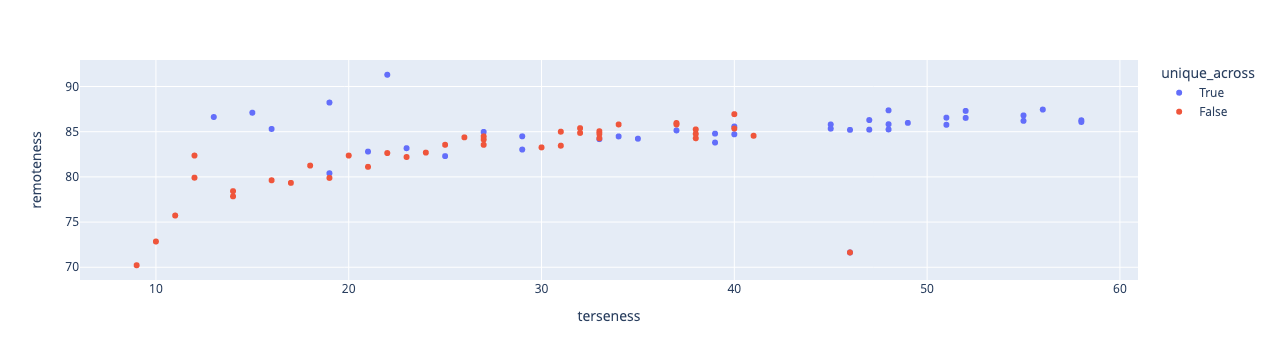

In [36]:
px.scatter(df, x="terseness", y="remoteness", hover_name="dialect", color="unique_across")

In [37]:
synthetic_specs(2, dt_by_spec,False)

['pretry\npretry\nProduction Budget\ndata/movies.csv',
 'pretry\npretry\nProduction Budget\nMPAA Rating\nMajor Genre\ndata/movies.csv',
 'cynodont\npretry\nMPAA Rating\nMajor Genre\ndata/movies.csv',
 'pretry\ncynodont\nWorldwide Gross\nProduction Budget\nMPAA Rating\ndata/movies.csv',
 'pretry\npretry\nProduction Budget\nMPAA Rating\ndata/movies.csv',
 'pretry\npretry\npretry\nWorldwide Gross\nRelease Date\ndata/movies.csv',
 'pretry\npretry\npretry\nProduction Budget\nMajor Genre\ndata/movies.csv',
 'cynodont\npretry\npretry\nWorldwide Gross\nProduction Budget\nMPAA Rating\ndata/movies.csv',
 'cynodont\npretry\ncynodont\nMajor Genre\ndata/movies.csv',
 'pretry\ncynodont\ncynodont\nMPAA Rating\nMajor Genre\ndata/movies.csv',
 'pretry\npretry\ncynodont\nProduction Budget\nMPAA Rating\nMajor Genre\ndata/movies.csv',
 'cynodont\npretry\npretry\ncynodont\nWorldwide Gross\nProduction Budget\nRelease Date\ndata/movies.csv',
 'pretry\npretry\ncynodont\nProduction Budget\nMajor Genre\ndata/mo